In [2]:
from skimage.feature import Cascade
from skimage import data
from matplotlib import patches

trained_file = data.lbp_frontal_face_cascade_filename()

face_detector = Cascade(trained_file)

In [1]:
import os
import sys
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import shap

In [3]:
CLASSES = ['neutral', 'happy', 'sad', 'surprised', 'fear', 'disgusted', 'angry', 'contempt']

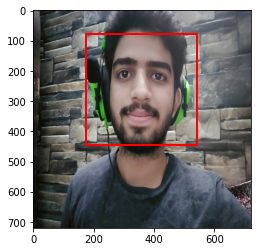

In [58]:
#test_img = os.path.join('dataset', 'images', 'val_class', 'class005', 'Test_1.jpg')
test_img = os.path.join('sample', 'Test_1.jpg')

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (720, 720))

detected = face_detector.detect_multi_scale(img=img,
                                           scale_factor = 1.2,
                                           step_ratio = 1,
                                           min_size = (360, 360),
                                           max_size = (720, 720))

plt.imshow(img)
img_desc = plt.gca()
plt.set_cmap('gray')

for patch in detected:
    
    img_desc.add_patch(
        patches.Rectangle(
            (patch['c'], patch['r']),
            patch['width'],
            patch['height'],
            fill = False,
            color = 'r',
            linewidth = 2
        )
    )

plt.grid(False)
plt.show()

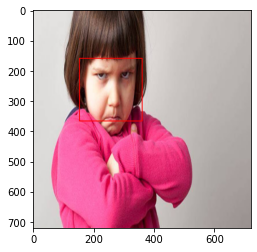

In [13]:
cv2.rectangle(img, (detected[0]['c'], detected[0]['r']),
              (detected[0]['height'] + detected[0]['c'], detected[0]['width'] + detected[0]['r']), 
              (255, 0, 0), 2)

plt.imshow(img)

In [66]:
def f(X):
    return load_model(X)

In [67]:
masker = shap.maskers.Image("inpaint_telea", cropped[0].shape)

In [68]:
explainer = shap.Explainer(f, masker, output_name = 'face')

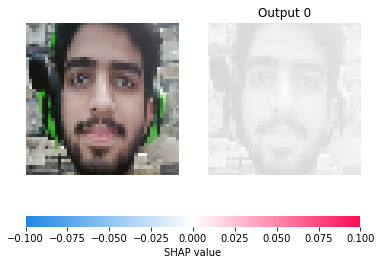

In [69]:
shap_values = explainer(cropped, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

In [16]:
print(detected)

[{'r': 159, 'c': 153, 'width': 207, 'height': 207}]


(224, 224, 3)


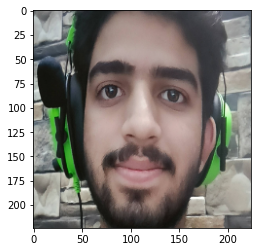

In [60]:
cropped_imgs = np.zeros((224, 224, 3))
flag = 0

for detect in detected:
    cropped = img[detect['r'] - 10:detect['height'] + detect['r'] + 10, detect['c'] - 10: detect['width'] + detect['c'] + 10]
    cropped = cv2.resize(cropped, (224, 224))
    if flag == 0:
        cropped_imgs = cropped
        flag = 1
    else:
        cropped_imgs = np.stack([cropped_imgs, cropped])
    
plt.imshow(cropped)

plt.grid(False)
print(cropped_imgs.shape)

In [59]:
cropped_imgs.shape

(224, 224, 3)

In [61]:
cropped = cv2.resize(cropped, (48, 48))

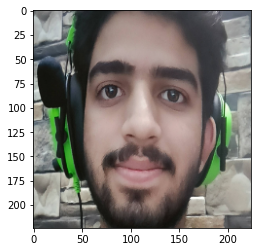

In [41]:
plt.imshow(cropped)

In [62]:
cropped = np.expand_dims(cropped, axis = 0)
cropped.shape

(1, 48, 48, 3)

In [53]:
load_model = tf.keras.models.load_model(os.path.join('trained_models', 'Facial Emotion DenseNet.h5'))

In [55]:
imgcopy = cv2.resize(img, (48, 48))
imgcopy = np.expand_dims(imgcopy, axis = 0)

In [63]:
predictions = load_model.predict(cropped)

1/1 [==============================] - 3s 3s/step


In [50]:
label_id = np.argmax(predictions, axis = -1)

In [64]:
label_id

array([6], dtype=int64)

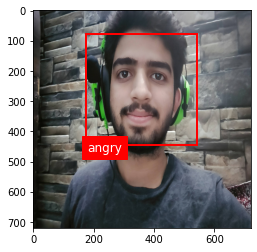

In [65]:
plt.imshow(img)
img_desc = plt.gca()
#plt.set_cmap('gray')

for patch, label in zip(detected, label_id):
    
    img_desc.add_patch(
        patches.Rectangle(
            (patch['c'], patch['r']),
            patch['width'],
            patch['height'],
            fill = False,
            color = 'r',
            linewidth = 2,
        )
    )
    plt.text(patch['c']+5, patch['r'] + patch['height']+20, CLASSES[label] , backgroundcolor = 'r', color = 'w', fontsize = 12)

plt.grid(False)
plt.show()

In [11]:
def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()
    frame = frame[100:820, 100:820, :]
    frame = change_brightness(frame, 30)
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (224, 224))
    
    detected = face_detector.detect_multi_scale(img=resized,
                                           scale_factor = 1.2,
                                           step_ratio = 1,
                                           min_size = (4, 4),
                                           max_size = (1080, 1080))
    
    cropped_imgs = np.zeros((1, 224, 224, 3))
    flag = 0
    '''
    for detect in detected:
        cropped = resized[detect['r'] - 10:detect['height'] + detect['r'] + 10,
                          detect['c'] - 10: detect['width'] + detect['c'] + 10]
        cropped = tf.image.resize(cropped, (224, 224))
        cropped = np.expand_dims(cropped, axis = 0)
        if flag == 0:
            cropped_imgs = cropped
            flag = 1
        else:
            cropped_imgs = np.concatenate([cropped_imgs, cropped])
    '''
    
    resized = np.expand_dims(resized, axis = 0)
            
    predictions = load_model.predict(resized, verbose=0)
    
    label_id = np.argmax(predictions, axis = -1)
    
    for patch, label in zip(detected, label_id):
    
        cv2.rectangle(frame, (patch['c'], patch['r']),
              (patch['height'] + patch['c'], patch['width'] + patch['r']), 
              (255, 0, 0), 2)
        cv2.putText(frame, CLASSES[label], (patch['c'], patch['r'] + patch['height']+10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Emotion', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [10]:
import cv2
  
  
# define a video capture object
vid = cv2.VideoCapture(0)
  
while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
    frame = frame[0:1080, 0:1080, :]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (224, 224))
    
    detected = face_detector.detect_multi_scale(img=resized,
                                           scale_factor = 1.2,
                                           step_ratio = 1,
                                           min_size = (4, 4),
                                           max_size = (1080, 1080))
    
    for patch in detected:
    
        cv2.rectangle(frame, (patch['c'], patch['r']),
              (patch['height'] + patch['c'], patch['width'] + patch['r']), 
              (255, 0, 0), 2)
        #cv2.putText(frame, CLASSES[label], (patch['c'], patch['r'] + patch['height']+10),
                    #cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
  
    # Display the resulting frame
    cv2.imshow('frame', frame)
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()